In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

noise=True
snr=100.0

In [2]:
def gaussian_component(t, A, t0, sigma):
    return (A * np.exp(-(t - t0)**2 / (2.0 * sigma**2)))


def intrinsic_profile(t, components, normalize=True):
        profile = np.zeros(n_bins)
        for comp in components:
            profile += gaussian_component(t, comp['A'], comp['t0'], comp['sigma'])        
        if normalize:
            profile /= np.max(profile)        
        return (profile)

def pulse_broadening_function(n_bins, tau_sc):
        pbf = np.zeros(n_bins)        
        # One-sided exponential: g(t) = (1/tau_sc) * exp(-t/tau_sc) * H(t)
        for i in range(n_bins):
            if i >= 0:  # Heaviside function
                pbf[i] = (1.0 / tau_sc) * np.exp(-i / tau_sc)        
        # Normalize to unit area (sum = 1 for discrete case)
        pbf /= np.sum(pbf)        
        return pbf

def instrumental_response(n_bins, response_type='square', bin_width=1):
        response = np.zeros(n_bins)
        
        if response_type == 'square':
            # Square/rectangular function with width = bin_width
            response[:bin_width] = 1.0 / bin_width  # Normalize to unit area
        elif response_type == 'delta':
            # Delta function (idealized)
            response[0] = 1.0
        response /= np.sum(response)        
        return response
    
def system_response(n_bins, tau_sc, inst_width=1.0):
        pbf = pulse_broadening_function(n_bins,tau_sc)   #g(t)
        R = instrumental_response(n_bins, response_type='square')     #I(t)
        
        # Convolve using FFT (circular convolution)
        S = np.fft.ifft(np.fft.fft(pbf) * np.fft.fft(R)).real           # g(t) * I(t)
        
        # Normalize
        S /= np.sum(S)
        
        return S
        
def convolve_profile(profile, kernel):
        # Use FFT for circular convolution
        profile_fft = np.fft.fft(profile)
        kernel_fft = np.fft.fft(kernel)
        convolved = np.fft.ifft(profile_fft * kernel_fft).real        
        return convolved

def add_noise(n_bins, profile, snr):
        peak = np.max(profile)
        sigma_n = peak / snr
        
        noise = np.random.normal(0, sigma_n, n_bins)
        noisy_profile = profile + noise

        
        
        return noisy_profile, sigma_n


0.0019569471624266144


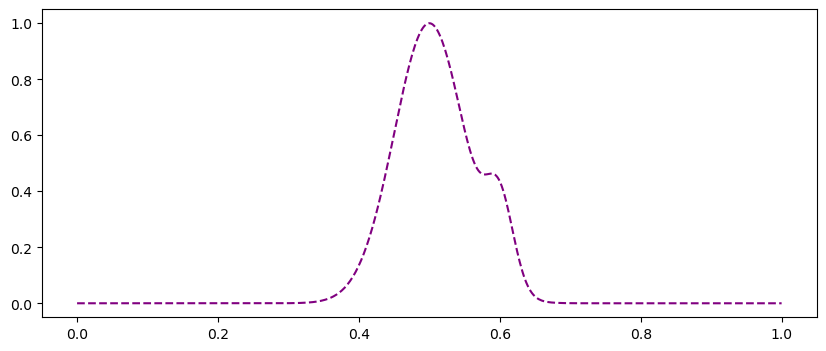

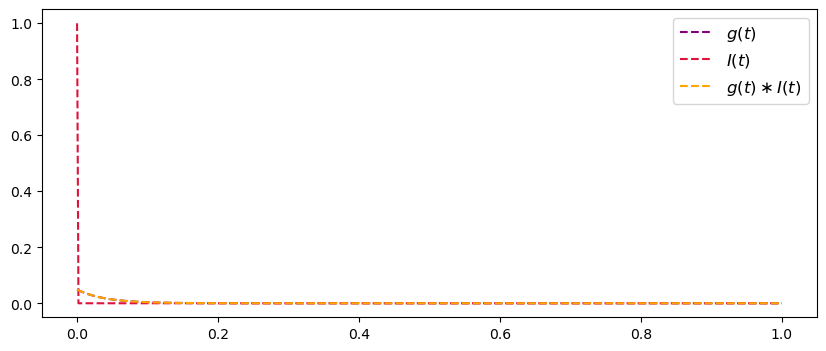

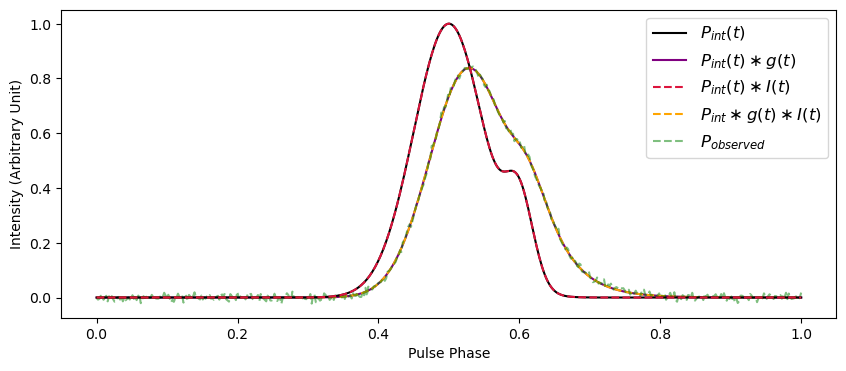

In [3]:
np.random.seed(42)
n_bins=512
t = np.linspace(0, 1, n_bins)

data_resolution=(t[1]-t[0])
print (data_resolution)
components = [
        {"A": 10.0, "t0": 0.5, "sigma": 0.05},  # Main peak
        {"A": 3.0,  "t0": 0.6, "sigma": 0.02},  # Sub-component
]

tau_sc = 20.0  # Scattering timescale in bins
#inst_width = 2.0  # Instrumental width
#snr = 50.0  # Signal-to-noise ratio
P = intrinsic_profile(t, components, normalize=True)                 # Intrinsic profile

S = pulse_broadening_function(n_bins, tau_sc)                        # g(t) --> Pulse brodening function
S_inst=instrumental_response(n_bins, response_type='square')          # I(t) --> Instrumental response function
S_I=system_response(n_bins, tau_sc, inst_width=2.0)                  # g(t) * I(t)  --> System Response (DIRTY BEAM)

O_ideal = convolve_profile(P, S)                                     # P_int * g(t)
O_ideal_inst = convolve_profile(P, S_inst)                           # P_int * I(t)
O_ideal_I = convolve_profile(P, S_I)                                 # P_int * g(t) * I(t)

# Adding noise to data
O_observed, sigma_n = add_noise(n_bins, O_ideal_I, snr)

#Making dictionary to keep data more organized
if snr is not None and snr > 0:
    O_observed, sigma_n = add_noise(n_bins, O_ideal_I, snr)
    my_dict = {
    'intrinsic': P,
    'pbf': S,
    'inst_response': S_inst,
    'dirty_beam': S_I,
    'convolved': O_ideal_I,
    'observed': O_observed,
    'noise_sigma': sigma_n
}
else:
    my_dict = {
    'intrinsic': P,
    'pbf': S,
    'inst_response': S_inst,
    'dirty_beam': S_I,
    'convolved': O_ideal_I,
    'observed': O_ideal_I,
    'noise_sigma': sigma_n
}

plt.figure(figsize=(10,4))
#Plotting Intrinsic profile
plt.plot(t,P,linestyle='--',color='purple')
plt.show()

#Plotting system reponses
plt.figure(figsize=(10,4))
plt.plot(t,S,linestyle='--',color='purple',label=r'$g(t)$')
plt.plot(t,S_inst,linestyle='--',color='crimson',label=r'$I(t)$')
plt.plot(t,S_I,linestyle='--',color='orange',label=r'$g(t) \ast I(t)$')
plt.legend(loc='best',prop={'size':12})
plt.show()

#Plotting convoluted profiles
plt.figure(figsize=(10,4))
plt.plot(t,P,linestyle='-',color='black',zorder=15,label=r'$P_{int}(t)$')
plt.plot(t,O_ideal,linestyle='-',color='purple',label=r'$P_{int}(t) \ast g(t)$')
plt.plot(t,O_ideal_inst,linestyle='--',color='crimson',label=r'$P_{int}(t) \ast I(t)$',zorder=16)
plt.plot(t,O_ideal_I,linestyle='--',color='orange',label=r'$P_{int} \ast g(t) \ast I(t)$')


plt.plot(t,O_observed,linestyle='--',color='green',label=r'$P_{observed}$',alpha=0.5)
plt.legend(loc='best',prop={'size':12})
plt.xlabel('Pulse Phase',size=10)
plt.ylabel('Intensity (Arbitrary Unit)',size=10)
#plt.savefig('Pulse_profiles.pdf')
plt.savefig("Pulse_profiles.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [4]:
# #Getting noise floor --> off-pulse RMS 
# plt.plot(t,O_observed,linestyle='--',color='green',label=r'$P_{observed}$',alpha=0.5)
# O_thresh = O_observed[O_observed < np.median(O_observed)]

# plt.axhline(y=np.mean(O_thresh),color='grey',linestyle='--',label='median of observed pulse')

# plt.axhspan(np.mean(O_thresh) + (3 * np.std(O_thresh)),np.mean(O_thresh) - (3 * np.std(O_thresh)), color='crimson' ,alpha=0.4)
# print (np.std(O_thresh))

In [5]:
def find_peak(residual):
    """Find position and value of peak in residual."""
    peak_idx = np.argmax(np.abs(residual))    
    peak_val = residual[peak_idx]
    return peak_idx, peak_val

def shift_beam(self, shift):
        """Circularly shift dirty beam."""
        return np.roll(self.dirty_beam, shift)

def calculate_off_pulse_rms(profile, method='fft'):
    """Calculate off-pulse RMS using FFT method from paper."""
    n_bins = len(profile)
    
    if method == 'fft':
        profile_fft = np.fft.fft(profile)
        start_exclude = n_bins // 6
        end_exclude = 5 * n_bins // 6
        profile_fft_filtered = profile_fft.copy()
        profile_fft_filtered[start_exclude:end_exclude] = 0
        off_pulse_profile = np.fft.ifft(profile_fft_filtered)
        sigma_off = np.std(np.abs(off_pulse_profile)) * np.sqrt(2)
        return sigma_off, np.abs(off_pulse_profile)
    else:
        median_val = np.median(profile)
        off_pulse_mask = profile < median_val
        off_pulse_values = profile[off_pulse_mask]
        sigma_off = np.std(off_pulse_values)
        off_pulse_profile = np.where(off_pulse_mask, profile, 0)
        return sigma_off, off_pulse_profile

def clean_iteration(residual_pulse):
    #print ('Hello')
    # Step 1: Find location of maximum (CC)
    maxima_index, pulse_maxima, = find_peak(residual_pulse)
    #print ('pulse_maxima',pulse_maxima)
    # Step 2: Create CLEAN component 
    cc_amplitude = gain * pulse_maxima
    # Step 3: Create delta function at peak location
    delta = np.zeros(n_bins)
    delta[maxima_index] = cc_amplitude
    # Step 4: Convolve with PBF and instrumental response
    # Convolve: delta * g(t) * r(t)
    convolve_CC=  convolve_profile(delta, dirty_beam)
    # Step 5: Subtract from residual
    new_residual = residual_pulse - convolve_CC
    #plt.plot(t,convolve_CC)
    plt.plot(t,new_residual,zorder=2)
    return (new_residual,maxima_index,pulse_maxima,convolve_CC)
    #residual_pulse=new_residual

In [6]:
#Inputs for Clean algortihm
P_observed = np.array(my_dict['observed'])
dirty_beam = np.array(my_dict['dirty_beam'])
gain = 0.1
max_iterations=50000
#n_bins = len(P_observed)
        
# Initialize residual to observed profile
residual = P_observed.copy()
        
# CLEAN components (delta functions)
clean_components = np.zeros(n_bins)
        
# Use 3-sigma of off-pulse region as threshold
off_pulse = P_observed[P_observed < np.median(P_observed)]
threshold = 3 * np.std(off_pulse)

### Clean decomposition

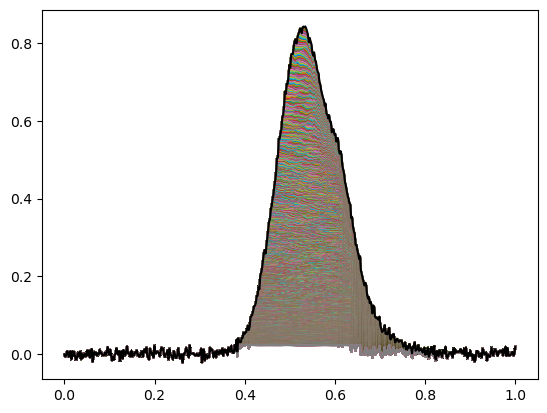

In [7]:
#Estimating off pulse RMS 
sigma_off_fft, _ = calculate_off_pulse_rms(P_observed, method='fft')
sigma_off_simple, _ = calculate_off_pulse_rms(P_observed, method='simple')
threshold= (3*sigma_off_simple)
plt.plot(t,P_observed,color='black',zorder=15)


iteration_history = {
        'profiles': [residual.copy()],
        'max_values': [],
        'max_positions': [],
        'subtractions': []}
    
iteration=0
clean_components = []
while iteration < max_iterations:
    # Check termination criterion
    #max_residual = np.max(residual)
    maxima_index, pulse_maxima, = find_peak(residual)
    #print ('max_residual',max_residual)
    #print ('threshold',threshold)
    if (pulse_maxima < threshold):
        break
    if (pulse_maxima > threshold):
        # Perform CLEAN iteration
        new_residual, cc_index, cc_amp, subtraction = clean_iteration(residual)
        clean_components.append((cc_amp, cc_index)) 
        residual=new_residual
        # Track history
        iteration_history['max_values'].append(cc_amp)
        iteration_history['max_positions'].append(cc_index)
        iteration_history['subtractions'].append(subtraction)
        iteration_history['profiles'].append(residual.copy())
        iteration += 1


# Check if we hit max iterations
if iteration >= max_iterations:
        print(f"\n⚠ Warning: Reached maximum iterations ({max_iterations})")
        print(f"  Final max: {np.max(residual):.6f}")
        print(f"  Threshold: {threshold:.6f}")
        print(f"  You may need to increase max_iterations or adjust gamma")
        
clean_components=np.array(clean_components)
plt.savefig('residual_profiles.pdf', bbox_inches='tight')
plt.show()


### Visualize the distribution of CLEAN components.

4208


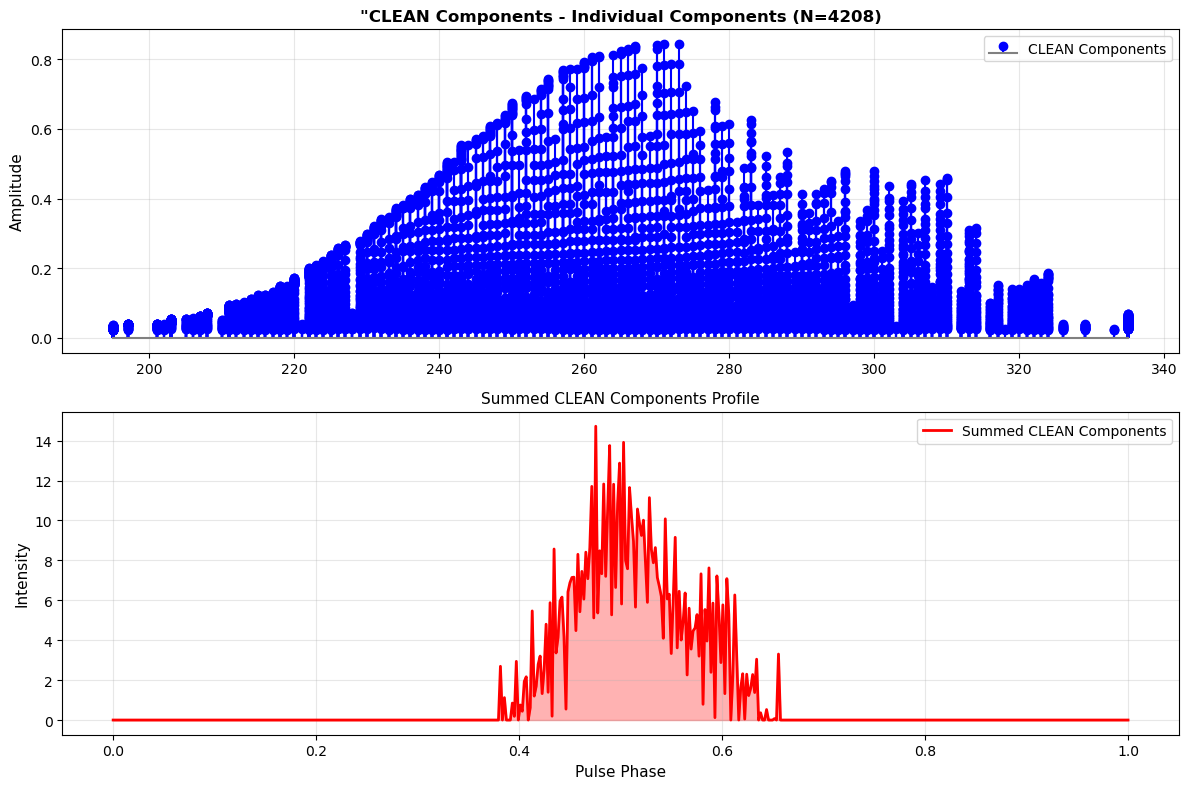

In [8]:
# Extract positions and amplitudes
amplitudes = np.array([cc[0] for cc in clean_components])
positions = np.array([cc[1] for cc in clean_components])

# Create histogram of CC positions
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: CC amplitude vs position (stem plot)
ax1 = axes[0]
ax1.stem(positions, amplitudes, linefmt='b-', markerfmt='bo', 
         basefmt='gray', label='CLEAN Components')
ax1.set_ylabel('Amplitude', fontsize=11)
ax1.set_title(f'"CLEAN Components - Individual Components (N={len(clean_components)})', 
              fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(alpha=0.3)

print (len(clean_components))
#print (clean_components[0])
# Plot 2: Summed CC profile
ax2 = axes[1]
cc_profile = np.zeros(n_bins)
for i in range(0,len(clean_components)):
    amp=clean_components[i][0]
    pos=int(clean_components[i][1])
    cc_profile[pos] += amp
# for amp, pos  in clean_components:
#     cc_profile[pos] += amp

ax2.plot(t, cc_profile, 'r-', linewidth=2, label='Summed CLEAN Components')
ax2.fill_between(t, 0, cc_profile, color='red', alpha=0.3)
ax2.set_xlabel('Pulse Phase', fontsize=11)
ax2.set_ylabel('Intensity', fontsize=11)
ax2.set_title('Summed CLEAN Components Profile', fontsize=11)
ax2.legend(loc='upper right')
ax2.grid(alpha=0.3)
plt.savefig('CLEAN_Components.pdf', bbox_inches='tight')
plt.tight_layout()


### Displaying few iterations to see if everything looks okay

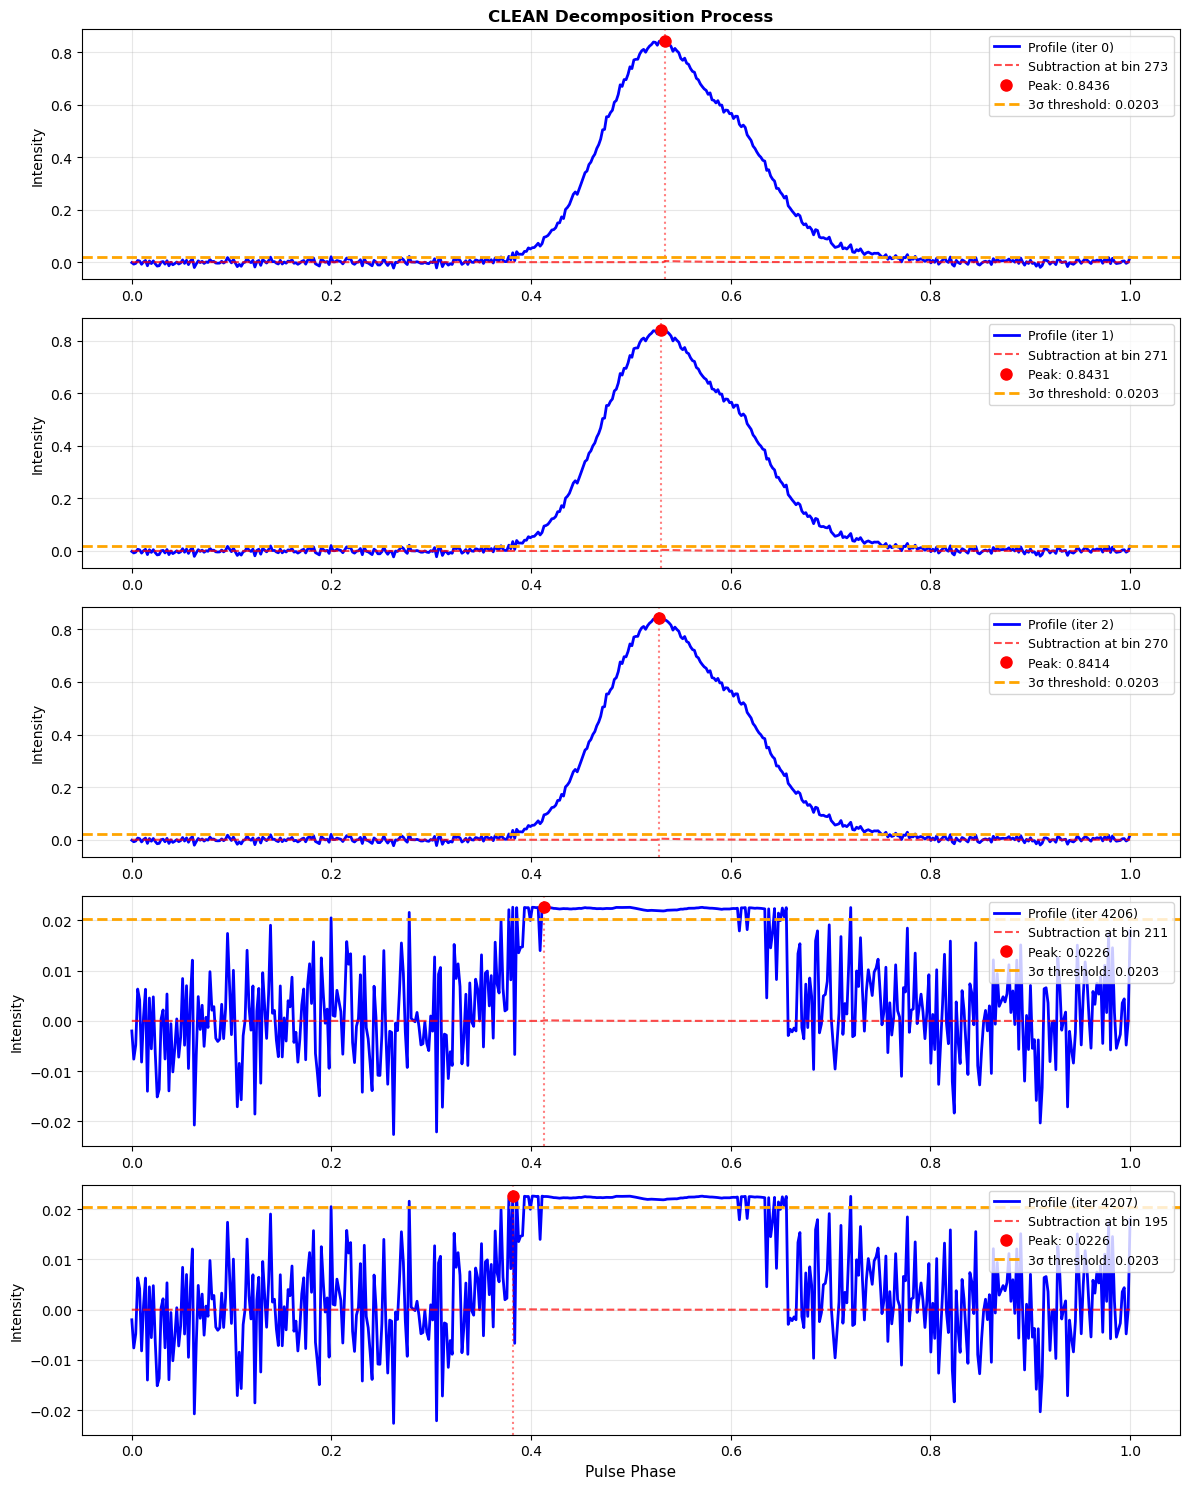

In [9]:

n_show=5
total_iterations = len(iteration_history['profiles']) - 1

# Select iterations to show (logarithmically spaced + first few + last)
if total_iterations <= n_show:
    show_indices = list(range(total_iterations))
else:
    # First 2, last 1, and log-spaced in between
    first_iters = [0, 1]
    last_iter = [total_iterations - 1]
    middle_iters = np.logspace(np.log10(2), np.log10(total_iterations-2), 
                               n_show - 3).astype(int).tolist()
    show_indices = sorted(set(first_iters + middle_iters + last_iter))

n_plots = len(show_indices)
fig, axes = plt.subplots(n_plots, 1, figsize=(12, 3*n_plots))

if n_plots == 1:
    axes = [axes]

for i, iter_idx in enumerate(show_indices):
    ax = axes[i]
    profile = iteration_history['profiles'][iter_idx]
    
    # Plot current profile
    ax.plot(t, profile, 'b-', linewidth=2, label=f'Profile (iter {iter_idx})')
    
    # Show the subtraction if not the last iteration
    if iter_idx < total_iterations:
        max_pos = iteration_history['max_positions'][iter_idx]
        max_val = iteration_history['max_values'][iter_idx]
        subtraction = iteration_history['subtractions'][iter_idx]
        
        ax.plot(t, subtraction, 'r--', linewidth=1.5, alpha=0.7, 
               label=f'Subtraction at bin {max_pos}')
        ax.axvline(x=t[max_pos], color='red', linestyle=':', alpha=0.5)
        ax.plot(t[max_pos], max_val, 'ro', markersize=8, 
               label=f'Peak: {max_val:.4f}')
        #ax.set_ylim(-0.02,0.02)
    
    # Calculate and show threshold
    #sigma_off, _ = calculate_off_pulse_rms(observed, method='fft')
    #threshold = 3 * sigma_off
    ax.axhline(y=threshold, color='orange', linestyle='--', linewidth=2, 
              label=f'3σ threshold: {threshold:.4f}')
    
    ax.set_ylabel('Intensity', fontsize=10)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(alpha=0.3)
    
    if i == 0:
        ax.set_title('CLEAN Decomposition Process', fontsize=12, fontweight='bold')
    if i == n_plots - 1:
        ax.set_xlabel('Pulse Phase', fontsize=11)
plt.savefig('CLEAN_Decomposition_Process_check.pdf', bbox_inches='tight')
plt.tight_layout()

### Plot the convergence of the CLEAN algorithm for each iteration.

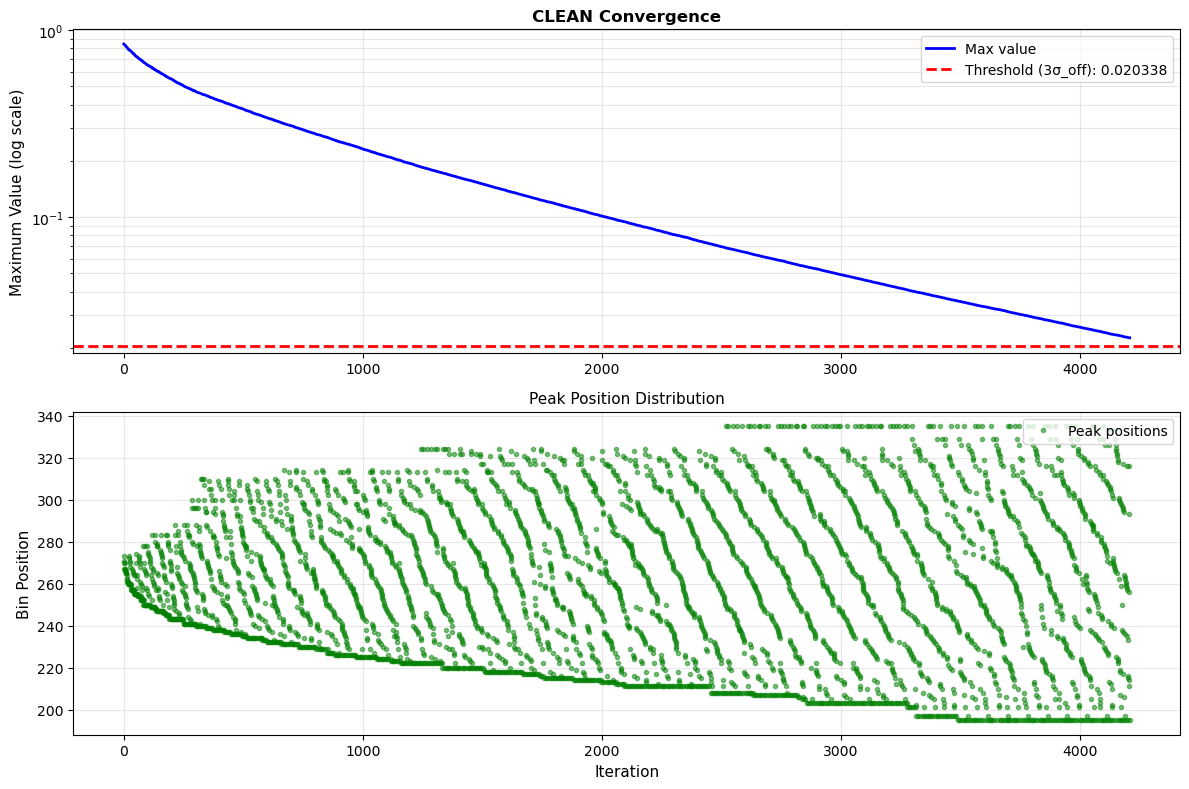

In [10]:


fig, axes = plt.subplots(2, 1, figsize=(12, 8))

iterations = range(len(iteration_history['max_values']))
max_vals = iteration_history['max_values']

# Plot 1: Maximum value vs iteration (log scale)
ax1 = axes[0]
ax1.semilogy(iterations, max_vals, 'b-', linewidth=2, label='Max value')
ax1.axhline(y=threshold, color='red', linestyle='--', linewidth=2, 
           label=f'Threshold (3σ_off): {threshold:.6f}')
ax1.set_ylabel('Maximum Value (log scale)', fontsize=11)
ax1.set_title('CLEAN Convergence', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(alpha=0.3, which='both')

# Plot 2: Position of maximum vs iteration
ax2 = axes[1]
positions = iteration_history['max_positions']
ax2.plot(iterations, positions, 'go', markersize=3, alpha=0.5, label='Peak positions')
ax2.set_xlabel('Iteration', fontsize=11)
ax2.set_ylabel('Bin Position', fontsize=11)
ax2.set_title('Peak Position Distribution', fontsize=11)
ax2.legend(loc='upper right')
ax2.grid(alpha=0.3)
plt.savefig('convergence.pdf', bbox_inches='tight')
plt.tight_layout()

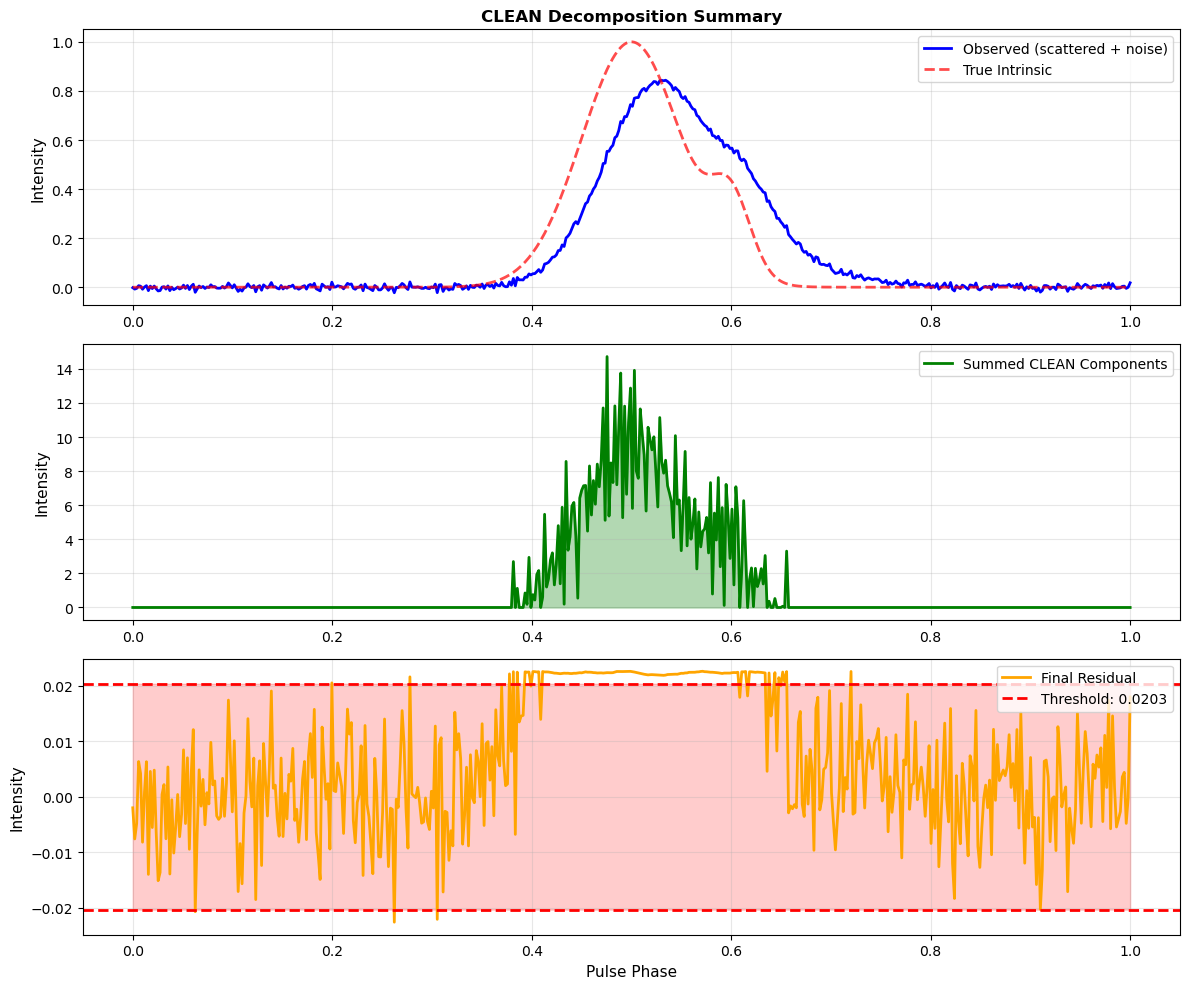

In [11]:
# Plot 4: Summary comparison
fig4, axes = plt.subplots(3, 1, figsize=(12, 10))

ax1 = axes[0]
ax1.plot(t, O_observed, 'b-', linewidth=2, label='Observed (scattered + noise)')
ax1.plot(t, P, 'r--', linewidth=2, label='True Intrinsic', alpha=0.7)
ax1.set_ylabel('Intensity', fontsize=11)
ax1.set_title('CLEAN Decomposition Summary', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(alpha=0.3)

ax2 = axes[1]
#print (clean_components)

# cc_profile = np.zeros(n_bins)
# for i in range(0,len(clean_components)):
#     amp=clean_components[i][0]
#     pos=int(clean_components[i][1])
#     cc_profile[pos] += amp

ax2.plot(t, cc_profile, 'g-', linewidth=2, label='Summed CLEAN Components')
ax2.fill_between(t, 0, cc_profile, color='green', alpha=0.3)
ax2.set_ylabel('Intensity', fontsize=11)
ax2.legend(loc='upper right')
ax2.grid(alpha=0.3)

ax3 = axes[2]
final_residual_profile=residual
ax3.plot(t, residual, 'orange', linewidth=2, label='Final Residual')
ax3.axhline(y=threshold, color='red', linestyle='--', linewidth=2,
           label=f'Threshold: {threshold:.4f}')
ax3.axhline(y=-threshold, color='red', linestyle='--', linewidth=2)
ax3.fill_between(t, -threshold, threshold, color='red', alpha=0.2)
ax3.set_xlabel('Pulse Phase', fontsize=11)
ax3.set_ylabel('Intensity', fontsize=11)
ax3.legend(loc='upper right')
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('clean_summary.pdf', bbox_inches='tight')
plt.show()

0.24987746218473272


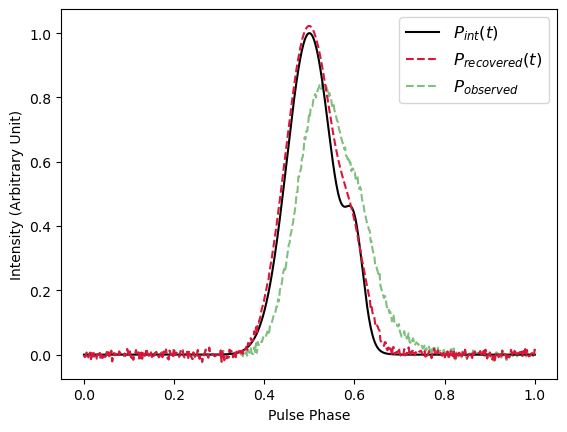

In [12]:
sigma=np.std(O_observed)
print (sigma)
restoring_profile = np.zeros(n_bins)
for i in range(0,len(clean_components)):
    amp=clean_components[i][0]
    pos=int(clean_components[i][1])
    #print (amp,pos)
    #cc_profile[pos] += amp
    restoring_function= gaussian_component(t, amp, t[pos], 0.02)
    restoring_profile +=restoring_function
    #plt.axvline(x=t[pos])
    #plt.plot(t,restoring_function)
    restoring_function /= np.sum(restoring_function)
    #plt.ylim(-0.001,0.001)
    #plt.show()

#restoring_profile=
restoring_profile /= np.max(restoring_profile)

restoring_profile = restoring_profile + residual
plt.plot(t,P,linestyle='-',color='black',zorder=15,label=r'$P_{int}(t)$')
plt.plot(t,restoring_profile,linestyle='--',color='crimson',zorder=15,label=r'$P_{recovered}(t)$')


plt.plot(t,O_observed,linestyle='--',color='green',label=r'$P_{observed}$',alpha=0.5)
plt.legend(loc='best',prop={'size':12})
plt.xlabel('Pulse Phase',size=10)
plt.ylabel('Intensity (Arbitrary Unit)',size=10)
plt.show()